This file contains code for use with "Think Bayes",
by Allen B. Downey, available from greenteapress.com

Copyright 2012 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""

"""This file contains class definitions for:

Hist: represents a histogram (map from values to integer frequencies).

Pmf: represents a probability mass function (map from values to probs).

_DictWrapper: private parent class for Hist and Pmf.

Cdf: represents a discrete cumulative distribution function

Pdf: represents a continuous probability density function

In [1]:
import bisect
import copy
import logging
import math
import numpy
import random

import scipy.stats
from scipy.special import erf, erfinv


def Odds(p):
    """Computes odds for a given probability.

    Example: p=0.75 means 75 for and 25 against, or 3:1 odds in favor.

    Note: when p=1, the formula for odds divides by zero, which is
    normally undefined.  But I think it is reasonable to define Odds(1)
    to be infinity, so that's what this function does.

    p: float 0-1

    Returns: float odds
    """
    if p == 1:
        return float('inf')
    return p / (1 - p)


def Probability(o):
    """Computes the probability corresponding to given odds.

    Example: o=2 means 2:1 odds in favor, or 2/3 probability

    o: float odds, strictly positive

    Returns: float probability
    """
    return o / (o + 1)


def Probability2(yes, no):
    """Computes the probability corresponding to given odds.

    Example: yes=2, no=1 means 2:1 odds in favor, or 2/3 probability.
    
    yes, no: int or float odds in favor
    """
    return float(yes) / (yes + no)


class Interpolator(object):
    """Represents a mapping between sorted sequences; performs linear interp.

    Attributes:
        xs: sorted list
        ys: sorted list
    """

    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys

    def Lookup(self, x):
        """Looks up x and returns the corresponding value of y."""
        return self._Bisect(x, self.xs, self.ys)

    def Reverse(self, y):
        """Looks up y and returns the corresponding value of x."""
        return self._Bisect(y, self.ys, self.xs)

    def _Bisect(self, x, xs, ys):
        """Helper function."""
        if x <= xs[0]:
            return ys[0]
        if x >= xs[-1]:
            return ys[-1]
        i = bisect.bisect(xs, x)
        frac = 1.0 * (x - xs[i - 1]) / (xs[i] - xs[i - 1])
        y = ys[i - 1] + frac * 1.0 * (ys[i] - ys[i - 1])
        return y


class _DictWrapper(object):
    """An object that contains a dictionary."""

    def __init__(self, values=None, name=''):
        """Initializes the distribution.

        hypos: sequence of hypotheses
        """
        self.name = name
        self.d = {}

        # flag whether the distribution is under a log transform
        self.log = False

        if values is None:
            return

        init_methods = [
            self.InitPmf,
            self.InitMapping,
            self.InitSequence,
            self.InitFailure,
            ]

        for method in init_methods:
            try:
                method(values)
                break
            except AttributeError:
                continue

        if len(self) > 0:
            self.Normalize()

    def InitSequence(self, values):
        """Initializes with a sequence of equally-likely values.

        values: sequence of values
        """
        for value in values:
            self.Set(value, 1)

    def InitMapping(self, values):
        """Initializes with a map from value to probability.

        values: map from value to probability
        """
        for value, prob in values.iteritems():
            self.Set(value, prob)

    def InitPmf(self, values):
        """Initializes with a Pmf.

        values: Pmf object
        """
        for value, prob in values.Items():
            self.Set(value, prob)

    def InitFailure(self, values):
        """Raises an error."""
        raise ValueError('None of the initialization methods worked.')

    def __len__(self):
        return len(self.d)

    def __iter__(self):
        return iter(self.d)

    def iterkeys(self):
        return iter(self.d)

    def __contains__(self, value):
        return value in self.d

    def Copy(self, name=None):
        """Returns a copy.

        Make a shallow copy of d.  If you want a deep copy of d,
        use copy.deepcopy on the whole object.

        Args:
            name: string name for the new Hist
        """
        new = copy.copy(self)
        new.d = copy.copy(self.d)
        new.name = name if name is not None else self.name
        return new

    def Scale(self, factor):
        """Multiplies the values by a factor.

        factor: what to multiply by

        Returns: new object
        """
        new = self.Copy()
        new.d.clear()

        for val, prob in self.Items():
            new.Set(val * factor, prob)
        return new

    def Log(self, m=None):
        """Log transforms the probabilities.
        
        Removes values with probability 0.

        Normalizes so that the largest logprob is 0.
        """
        if self.log:
            raise ValueError("Pmf/Hist already under a log transform")
        self.log = True

        if m is None:
            m = self.MaxLike()

        for x, p in self.d.iteritems():
            if p:
                self.Set(x, math.log(p / m))
            else:
                self.Remove(x)

    def Exp(self, m=None):
        """Exponentiates the probabilities.

        m: how much to shift the ps before exponentiating

        If m is None, normalizes so that the largest prob is 1.
        """
        if not self.log:
            raise ValueError("Pmf/Hist not under a log transform")
        self.log = False

        if m is None:
            m = self.MaxLike()

        for x, p in self.d.iteritems():
            self.Set(x, math.exp(p - m))

    def GetDict(self):
        """Gets the dictionary."""
        return self.d

    def SetDict(self, d):
        """Sets the dictionary."""
        self.d = d

    def Values(self):
        """Gets an unsorted sequence of values.

        Note: one source of confusion is that the keys of this
        dictionary are the values of the Hist/Pmf, and the
        values of the dictionary are frequencies/probabilities.
        """
        return self.d.keys()

    def Items(self):
        """Gets an unsorted sequence of (value, freq/prob) pairs."""
        return self.d.items()

    def Render(self):
        """Generates a sequence of points suitable for plotting.

        Returns:
            tuple of (sorted value sequence, freq/prob sequence)
        """
        return zip(*sorted(self.Items()))

    def Print(self):
        """Prints the values and freqs/probs in ascending order."""
        for val, prob in sorted(self.d.iteritems()):
            print (val, prob)

    def Set(self, x, y=0):
        """Sets the freq/prob associated with the value x.

        Args:
            x: number value
            y: number freq or prob
        """
        self.d[x] = y

    def Incr(self, x, term=1):
        """Increments the freq/prob associated with the value x.

        Args:
            x: number value
            term: how much to increment by
        """
        self.d[x] = self.d.get(x, 0) + term

    def Mult(self, x, factor):
        """Scales the freq/prob associated with the value x.

        Args:
            x: number value
            factor: how much to multiply by
        """
        self.d[x] = self.d.get(x, 0) * factor

    def Remove(self, x):
        """Removes a value.

        Throws an exception if the value is not there.

        Args:
            x: value to remove
        """
        del self.d[x]

    def Total(self):
        """Returns the total of the frequencies/probabilities in the map."""
        total = 0
        for x in self.d.values():
            total = total + x
        #total = sum(self.d.itervalues())
        return total

    def MaxLike(self):
        """Returns the largest frequency/probability in the map."""
        return max(self.d.itervalues())


class Hist(_DictWrapper):
    """Represents a histogram, which is a map from values to frequencies.

    Values can be any hashable type; frequencies are integer counters.
    """

    def Freq(self, x):
        """Gets the frequency associated with the value x.

        Args:
            x: number value

        Returns:
            int frequency
        """
        return self.d.get(x, 0)

    def Freqs(self, xs):
        """Gets frequencies for a sequence of values."""
        return [self.Freq(x) for x in xs]

    def IsSubset(self, other):
        """Checks whether the values in this histogram are a subset of
        the values in the given histogram."""
        for val, freq in self.Items():
            if freq > other.Freq(val):
                return False
        return True

    def Subtract(self, other):
        """Subtracts the values in the given histogram from this histogram."""
        for val, freq in other.Items():
            self.Incr(val, -freq)


class Pmf(_DictWrapper):
    """Represents a probability mass function.
    
    Values can be any hashable type; probabilities are floating-point.
    Pmfs are not necessarily normalized.
    """

    def Prob(self, x, default=0):
        """Gets the probability associated with the value x.

        Args:
            x: number value
            default: value to return if the key is not there

        Returns:
            float probability
        """
        return self.d.get(x, default)

    def Probs(self, xs):
        """Gets probabilities for a sequence of values."""
        return [self.Prob(x) for x in xs]

    def MakeCdf(self, name=None):
        """Makes a Cdf."""
        return MakeCdfFromPmf(self, name=name)

    def ProbGreater(self, x):
        t = [prob for (val, prob) in self.d.iteritems() if val > x]
        return sum(t)

    def ProbLess(self, x):
        t = [prob for (val, prob) in self.d.iteritems() if val < x]
        return sum(t)

    def Normalize(self, fraction=1.0):
        """Normalizes this PMF so the sum of all probs is fraction.

        Args:
            fraction: what the total should be after normalization

        Returns: the total probability before normalizing
        """
        if self.log:
            raise ValueError("Pmf is under a log transform")

        total = self.Total()
        if total == 0.0:
            raise ValueError('total probability is zero.')
            logging.warning('Normalize: total probability is zero.')
            return total

        factor = float(fraction) / total
        for x in self.d:
            self.d[x] *= factor

        return total

    def Random(self):
        """Chooses a random element from this PMF.

        Returns:
            float value from the Pmf
        """
        if len(self.d) == 0:
            raise ValueError('Pmf contains no values.')

        target = random.random()
        total = 0.0
        for x, p in self.d.iteritems():
            total += p
            if total >= target:
                return x

        # we shouldn't get here
        assert False

    def Mean(self):
        """Computes the mean of a PMF.

        Returns:
            float mean
        """
        mu = 0.0
        for x, p in self.d.iteritems():
            mu += p * x
        return mu

    def Var(self, mu=None):
        """Computes the variance of a PMF.

        Args:
            mu: the point around which the variance is computed;
                if omitted, computes the mean

        Returns:
            float variance
        """
        if mu is None:
            mu = self.Mean()

        var = 0.0
        for x, p in self.d.iteritems():
            var += p * (x - mu) ** 2
        return var

    def MaximumLikelihood(self):
        """Returns the value with the highest probability.

        Returns: float probability
        """
        prob, val = max((prob, val) for val, prob in self.Items())
        return val

    def CredibleInterval(self, percentage=90):
        """Computes the central credible interval.

        If percentage=90, computes the 90% CI.

        Args:
            percentage: float between 0 and 100

        Returns:
            sequence of two floats, low and high
        """
        cdf = self.MakeCdf()
        return cdf.CredibleInterval(percentage)

    def __add__(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        try:
            return self.AddPmf(other)
        except AttributeError:
            return self.AddConstant(other)

    def AddPmf(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            for v2, p2 in other.Items():
                pmf.Incr(v1 + v2, p1 * p2)
        return pmf

    def AddConstant(self, other):
        """Computes the Pmf of the sum a constant and  values from self.

        other: a number

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            pmf.Set(v1 + other, p1)
        return pmf

    def __sub__(self, other):
        """Computes the Pmf of the diff of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            for v2, p2 in other.Items():
                pmf.Incr(v1 - v2, p1 * p2)
        return pmf

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.MakeCdf()
        cdf.ps = [p ** k for p in cdf.ps]
        return cdf


class Joint(Pmf):
    """Represents a joint distribution.

    The values are sequences (usually tuples)
    """

    def Marginal(self, i, name=''):
        """Gets the marginal distribution of the indicated variable.

        i: index of the variable we want

        Returns: Pmf
        """
        pmf = Pmf(name=name)
        for vs, prob in self.Items():
            pmf.Incr(vs[i], prob)
        return pmf

    def Conditional(self, i, j, val, name=''):
        """Gets the conditional distribution of the indicated variable.

        Distribution of vs[i], conditioned on vs[j] = val.

        i: index of the variable we want
        j: which variable is conditioned on
        val: the value the jth variable has to have

        Returns: Pmf
        """
        pmf = Pmf(name=name)
        for vs, prob in self.Items():
            if vs[j] != val: continue
            pmf.Incr(vs[i], prob)

        pmf.Normalize()
        return pmf

    def MaxLikeInterval(self, percentage=90):
        """Returns the maximum-likelihood credible interval.

        If percentage=90, computes a 90% CI containing the values
        with the highest likelihoods.

        percentage: float between 0 and 100

        Returns: list of values from the suite
        """
        interval = []
        total = 0

        t = [(prob, val) for val, prob in self.Items()]
        t.sort(reverse=True)

        for prob, val in t:
            interval.append(val)
            total += prob
            if total >= percentage / 100.0:
                break

        return interval


def MakeJoint(pmf1, pmf2):
    """Joint distribution of values from pmf1 and pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        Joint pmf of value pairs
    """
    joint = Joint()
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            joint.Set((v1, v2), p1 * p2)
    return joint


def MakeHistFromList(t, name=''):
    """Makes a histogram from an unsorted sequence of values.

    Args:
        t: sequence of numbers
        name: string name for this histogram

    Returns:
        Hist object
    """
    hist = Hist(name=name)
    [hist.Incr(x) for x in t]
    return hist


def MakeHistFromDict(d, name=''):
    """Makes a histogram from a map from values to frequencies.

    Args:
        d: dictionary that maps values to frequencies
        name: string name for this histogram

    Returns:
        Hist object
    """
    return Hist(d, name)


def MakePmfFromList(t, name=''):
    """Makes a PMF from an unsorted sequence of values.

    Args:
        t: sequence of numbers
        name: string name for this PMF

    Returns:
        Pmf object
    """
    hist = MakeHistFromList(t)
    d = hist.GetDict()
    pmf = Pmf(d, name)
    pmf.Normalize()
    return pmf


def MakePmfFromDict(d, name=''):
    """Makes a PMF from a map from values to probabilities.

    Args:
        d: dictionary that maps values to probabilities
        name: string name for this PMF

    Returns:
        Pmf object
    """
    pmf = Pmf(d, name)
    pmf.Normalize()
    return pmf


def MakePmfFromItems(t, name=''):
    """Makes a PMF from a sequence of value-probability pairs

    Args:
        t: sequence of value-probability pairs
        name: string name for this PMF

    Returns:
        Pmf object
    """
    pmf = Pmf(dict(t), name)
    pmf.Normalize()
    return pmf


def MakePmfFromHist(hist, name=None):
    """Makes a normalized PMF from a Hist object.

    Args:
        hist: Hist object
        name: string name

    Returns:
        Pmf object
    """
    if name is None:
        name = hist.name

    # make a copy of the dictionary
    d = dict(hist.GetDict())
    pmf = Pmf(d, name)
    pmf.Normalize()
    return pmf


def MakePmfFromCdf(cdf, name=None):
    """Makes a normalized Pmf from a Cdf object.

    Args:
        cdf: Cdf object
        name: string name for the new Pmf

    Returns:
        Pmf object
    """
    if name is None:
        name = cdf.name

    pmf = Pmf(name=name)

    prev = 0.0
    for val, prob in cdf.Items():
        pmf.Incr(val, prob - prev)
        prev = prob

    return pmf


def MakeMixture(metapmf, name='mix'):
    """Make a mixture distribution.

    Args:
      metapmf: Pmf that maps from Pmfs to probs.
      name: string name for the new Pmf.

    Returns: Pmf object.
    """
    mix = Pmf(name=name)
    for pmf, p1 in metapmf.Items():
        for x, p2 in pmf.Items():
            mix.Incr(x, p1 * p2)
    return mix


def MakeUniformPmf(low, high, n):
    """Make a uniform Pmf.

    low: lowest value (inclusive)
    high: highest value (inclusize)
    n: number of values
    """
    pmf = Pmf()
    for x in numpy.linspace(low, high, n):
        pmf.Set(x, 1)
    pmf.Normalize()
    return pmf


class Cdf(object):
    """Represents a cumulative distribution function.

    Attributes:
        xs: sequence of values
        ps: sequence of probabilities
        name: string used as a graph label.
    """

    def __init__(self, xs=None, ps=None, name=''):
        self.xs = [] if xs is None else xs
        self.ps = [] if ps is None else ps
        self.name = name

    def Copy(self, name=None):
        """Returns a copy of this Cdf.

        Args:
            name: string name for the new Cdf
        """
        if name is None:
            name = self.name
        return Cdf(list(self.xs), list(self.ps), name)

    def MakePmf(self, name=None):
        """Makes a Pmf."""
        return MakePmfFromCdf(self, name=name)

    def Values(self):
        """Returns a sorted list of values.
        """
        return self.xs

    def Items(self):
        """Returns a sorted sequence of (value, probability) pairs.

        Note: in Python3, returns an iterator.
        """
        return zip(self.xs, self.ps)

    def Append(self, x, p):
        """Add an (x, p) pair to the end of this CDF.

        Note: this us normally used to build a CDF from scratch, not
        to modify existing CDFs.  It is up to the caller to make sure
        that the result is a legal CDF.
        """
        self.xs.append(x)
        self.ps.append(p)

    def Shift(self, term):
        """Adds a term to the xs.

        term: how much to add
        """
        new = self.Copy()
        new.xs = [x + term for x in self.xs]
        return new

    def Scale(self, factor):
        """Multiplies the xs by a factor.

        factor: what to multiply by
        """
        new = self.Copy()
        new.xs = [x * factor for x in self.xs]
        return new

    def Prob(self, x):
        """Returns CDF(x), the probability that corresponds to value x.

        Args:
            x: number

        Returns:
            float probability
        """
        if x < self.xs[0]: return 0.0
        index = bisect.bisect(self.xs, x)
        p = self.ps[index - 1]
        return p

    def Value(self, p):
        """Returns InverseCDF(p), the value that corresponds to probability p.

        Args:
            p: number in the range [0, 1]

        Returns:
            number value
        """
        if p < 0 or p > 1:
            raise ValueError('Probability p must be in range [0, 1]')

        if p == 0: return self.xs[0]
        if p == 1: return self.xs[-1]
        index = bisect.bisect(self.ps, p)
        if p == self.ps[index - 1]:
            return self.xs[index - 1]
        else:
            return self.xs[index]

    def Percentile(self, p):
        """Returns the value that corresponds to percentile p.

        Args:
            p: number in the range [0, 100]

        Returns:
            number value
        """
        return self.Value(p / 100.0)

    def Random(self):
        """Chooses a random value from this distribution."""
        return self.Value(random.random())

    def Sample(self, n):
        """Generates a random sample from this distribution.
        
        Args:
            n: int length of the sample
        """
        return [self.Random() for i in range(n)]

    def Mean(self):
        """Computes the mean of a CDF.

        Returns:
            float mean
        """
        old_p = 0
        total = 0.0
        for x, new_p in zip(self.xs, self.ps):
            p = new_p - old_p
            total += p * x
            old_p = new_p
        return total

    def CredibleInterval(self, percentage=90):
        """Computes the central credible interval.

        If percentage=90, computes the 90% CI.

        Args:
            percentage: float between 0 and 100

        Returns:
            sequence of two floats, low and high
        """
        prob = (1 - percentage / 100.0) / 2
        interval = self.Value(prob), self.Value(1 - prob)
        return interval

    def _Round(self, multiplier=1000.0):
        """
        An entry is added to the cdf only if the percentile differs
        from the previous value in a significant digit, where the number
        of significant digits is determined by multiplier.  The
        default is 1000, which keeps log10(1000) = 3 significant digits.
        """
        # TODO(write this method)
        raise UnimplementedMethodException()

    def Render(self):
        """Generates a sequence of points suitable for plotting.

        An empirical CDF is a step function; linear interpolation
        can be misleading.

        Returns:
            tuple of (xs, ps)
        """
        xs = [self.xs[0]]
        ps = [0.0]
        for i, p in enumerate(self.ps):
            xs.append(self.xs[i])
            ps.append(p)

            try:
                xs.append(self.xs[i + 1])
                ps.append(p)
            except IndexError:
                pass
        return xs, ps

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.Copy()
        cdf.ps = [p ** k for p in cdf.ps]
        return cdf


def MakeCdfFromItems(items, name=''):
    """Makes a cdf from an unsorted sequence of (value, frequency) pairs.

    Args:
        items: unsorted sequence of (value, frequency) pairs
        name: string name for this CDF

    Returns:
        cdf: list of (value, fraction) pairs
    """
    runsum = 0
    xs = []
    cs = []

    for value, count in sorted(items):
        runsum += count
        xs.append(value)
        cs.append(runsum)

    total = float(runsum)
    ps = [c / total for c in cs]

    cdf = Cdf(xs, ps, name)
    return cdf


def MakeCdfFromDict(d, name=''):
    """Makes a CDF from a dictionary that maps values to frequencies.

    Args:
       d: dictionary that maps values to frequencies.
       name: string name for the data.

    Returns:
        Cdf object
    """
    return MakeCdfFromItems(d.iteritems(), name)


def MakeCdfFromHist(hist, name=''):
    """Makes a CDF from a Hist object.

    Args:
       hist: Pmf.Hist object
       name: string name for the data.

    Returns:
        Cdf object
    """
    return MakeCdfFromItems(hist.Items(), name)


def MakeCdfFromPmf(pmf, name=None):
    """Makes a CDF from a Pmf object.

    Args:
       pmf: Pmf.Pmf object
       name: string name for the data.

    Returns:
        Cdf object
    """
    if name == None:
        name = pmf.name
    return MakeCdfFromItems(pmf.Items(), name)


def MakeCdfFromList(seq, name=''):
    """Creates a CDF from an unsorted sequence.

    Args:
        seq: unsorted sequence of sortable values
        name: string name for the cdf

    Returns:
       Cdf object
    """
    hist = MakeHistFromList(seq)
    return MakeCdfFromHist(hist, name)


class UnimplementedMethodException(Exception):
    """Exception if someone calls a method that should be overridden."""


class Suite(Pmf):
    """Represents a suite of hypotheses and their probabilities."""

    def Update(self, data):
        """Updates each hypothesis based on the data.

        data: any representation of the data

        returns: the normalizing constant
        """
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        return self.Normalize()

    def LogUpdate(self, data):
        """Updates a suite of hypotheses based on new data.

        Modifies the suite directly; if you want to keep the original, make
        a copy.

        Note: unlike Update, LogUpdate does not normalize.

        Args:
            data: any representation of the data
        """
        for hypo in self.Values():
            like = self.LogLikelihood(data, hypo)
            self.Incr(hypo, like)

    def UpdateSet(self, dataset):
        """Updates each hypothesis based on the dataset.

        This is more efficient than calling Update repeatedly because
        it waits until the end to Normalize.

        Modifies the suite directly; if you want to keep the original, make
        a copy.

        dataset: a sequence of data

        returns: the normalizing constant
        """
        for data in dataset:
            for hypo in self.Values():
                like = self.Likelihood(data, hypo)
                self.Mult(hypo, like)
        return self.Normalize()

    def LogUpdateSet(self, dataset):
        """Updates each hypothesis based on the dataset.

        Modifies the suite directly; if you want to keep the original, make
        a copy.

        dataset: a sequence of data

        returns: None
        """
        for data in dataset:
            self.LogUpdate(data)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: some representation of the hypothesis
        data: some representation of the data
        """
        raise UnimplementedMethodException()

    def LogLikelihood(self, data, hypo):
        """Computes the log likelihood of the data under the hypothesis.

        hypo: some representation of the hypothesis
        data: some representation of the data
        """
        raise UnimplementedMethodException()

    def Print(self):
        """Prints the hypotheses and their probabilities."""
        for hypo, prob in sorted(self.Items()):
            print (hypo, prob)

    def MakeOdds(self):
        """Transforms from probabilities to odds.

        Values with prob=0 are removed.
        """
        for hypo, prob in self.Items():
            if prob:
                self.Set(hypo, Odds(prob))
            else:
                self.Remove(hypo)

    def MakeProbs(self):
        """Transforms from odds to probabilities."""
        for hypo, odds in self.Items():
            self.Set(hypo, Probability(odds))


def MakeSuiteFromList(t, name=''):
    """Makes a suite from an unsorted sequence of values.

    Args:
        t: sequence of numbers
        name: string name for this suite

    Returns:
        Suite object
    """
    hist = MakeHistFromList(t)
    d = hist.GetDict()
    return MakeSuiteFromDict(d)


def MakeSuiteFromHist(hist, name=None):
    """Makes a normalized suite from a Hist object.

    Args:
        hist: Hist object
        name: string name

    Returns:
        Suite object
    """
    if name is None:
        name = hist.name

    # make a copy of the dictionary
    d = dict(hist.GetDict())
    return MakeSuiteFromDict(d, name)


def MakeSuiteFromDict(d, name=''):
    """Makes a suite from a map from values to probabilities.

    Args:
        d: dictionary that maps values to probabilities
        name: string name for this suite

    Returns:
        Suite object
    """
    suite = Suite(name=name)
    suite.SetDict(d)
    suite.Normalize()
    return suite


def MakeSuiteFromCdf(cdf, name=None):
    """Makes a normalized Suite from a Cdf object.

    Args:
        cdf: Cdf object
        name: string name for the new Suite

    Returns:
        Suite object
    """
    if name is None:
        name = cdf.name

    suite = Suite(name=name)

    prev = 0.0
    for val, prob in cdf.Items():
        suite.Incr(val, prob - prev)
        prev = prob

    return suite


class Pdf(object):
    """Represents a probability density function (PDF)."""

    def Density(self, x):
        """Evaluates this Pdf at x.

        Returns: float probability density
        """
        raise UnimplementedMethodException()

    def MakePmf(self, xs, name=''):
        """Makes a discrete version of this Pdf, evaluated at xs.

        xs: equally-spaced sequence of values

        Returns: new Pmf
        """
        pmf = Pmf(name=name)
        for x in xs:
            pmf.Set(x, self.Density(x))
        pmf.Normalize()
        return pmf


class GaussianPdf(Pdf):
    """Represents the PDF of a Gaussian distribution."""

    def __init__(self, mu, sigma):
        """Constructs a Gaussian Pdf with given mu and sigma.

        mu: mean
        sigma: standard deviation
        """
        self.mu = mu
        self.sigma = sigma

    def Density(self, x):
        """Evaluates this Pdf at x.

        Returns: float probability density
        """
        return EvalGaussianPdf(x, self.mu, self.sigma)


class EstimatedPdf(Pdf):
    """Represents a PDF estimated by KDE."""

    def __init__(self, sample):
        """Estimates the density function based on a sample.

        sample: sequence of data
        """
        self.kde = scipy.stats.gaussian_kde(sample)

    def Density(self, x):
        """Evaluates this Pdf at x.

        Returns: float probability density
        """
        return self.kde.evaluate(x)

    def MakePmf(self, xs, name=''):
        ps = self.kde.evaluate(xs)
        pmf = MakePmfFromItems(zip(xs, ps), name=name)
        return pmf


def Percentile(pmf, percentage):
    """Computes a percentile of a given Pmf.

    percentage: float 0-100
    """
    p = percentage / 100.0
    total = 0
    for val, prob in pmf.Items():
        total += prob
        if total >= p:
            return val


def CredibleInterval(pmf, percentage=90):
    """Computes a credible interval for a given distribution.

    If percentage=90, computes the 90% CI.

    Args:
        pmf: Pmf object representing a posterior distribution
        percentage: float between 0 and 100

    Returns:
        sequence of two floats, low and high
    """
    cdf = pmf.MakeCdf()
    prob = (1 - percentage / 100.0) / 2
    interval = cdf.Value(prob), cdf.Value(1 - prob)
    return interval


def PmfProbLess(pmf1, pmf2):
    """Probability that a value from pmf1 is less than a value from pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        float probability
    """
    total = 0.0
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            if v1 < v2:
                total += p1 * p2
    return total


def PmfProbGreater(pmf1, pmf2):
    """Probability that a value from pmf1 is less than a value from pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        float probability
    """
    total = 0.0
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            if v1 > v2:
                total += p1 * p2
    return total


def PmfProbEqual(pmf1, pmf2):
    """Probability that a value from pmf1 equals a value from pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        float probability
    """
    total = 0.0
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            if v1 == v2:
                total += p1 * p2
    return total


def RandomSum(dists):
    """Chooses a random value from each dist and returns the sum.

    dists: sequence of Pmf or Cdf objects

    returns: numerical sum
    """
    total = sum(dist.Random() for dist in dists)
    return total


def SampleSum(dists, n):
    """Draws a sample of sums from a list of distributions.

    dists: sequence of Pmf or Cdf objects
    n: sample size

    returns: new Pmf of sums
    """
    pmf = MakePmfFromList(RandomSum(dists) for i in xrange(n))
    return pmf


def EvalGaussianPdf(x, mu, sigma):
    """Computes the unnormalized PDF of the normal distribution.

    x: value
    mu: mean
    sigma: standard deviation
    
    returns: float probability density
    """
    return scipy.stats.norm.pdf(x, mu, sigma)


def MakeGaussianPmf(mu, sigma, num_sigmas, n=201):
    """Makes a PMF discrete approx to a Gaussian distribution.
    
    mu: float mean
    sigma: float standard deviation
    num_sigmas: how many sigmas to extend in each direction
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    low = mu - num_sigmas * sigma
    high = mu + num_sigmas * sigma

    for x in numpy.linspace(low, high, n):
        p = EvalGaussianPdf(x, mu, sigma)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf


def EvalBinomialPmf(k, n, p):
    """Evaluates the binomial pmf.

    Returns the probabily of k successes in n trials with probability p.
    """
    return scipy.stats.binom.pmf(k, n, p)
    

def EvalPoissonPmf(k, lam):
    """Computes the Poisson PMF.

    k: number of events
    lam: parameter lambda in events per unit time

    returns: float probability
    """
    # don't use the scipy function.  for lam=0 it returns NaN;
    # should be 0.0
    return scipy.stats.poisson.pmf(k, lam)

    #return lam ** k * math.exp(-lam) / math.factorial(k)


def MakePoissonPmf(lam, high, step=1):
    """Makes a PMF discrete approx to a Poisson distribution.

    lam: parameter lambda in events per unit time
    high: upper bound of the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    for k in xrange(0, high + 1, step):
        p = EvalPoissonPmf(k, lam)
        pmf.Set(k, p)
    pmf.Normalize()
    return pmf


def EvalExponentialPdf(x, lam):
    """Computes the exponential PDF.

    x: value
    lam: parameter lambda in events per unit time

    returns: float probability density
    """
    return lam * math.exp(-lam * x)


def EvalExponentialCdf(x, lam):
    """Evaluates CDF of the exponential distribution with parameter lam."""
    return 1 - math.exp(-lam * x)


def MakeExponentialPmf(lam, high, n=200):
    """Makes a PMF discrete approx to an exponential distribution.

    lam: parameter lambda in events per unit time
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    for x in numpy.linspace(0, high, n):
        p = EvalExponentialPdf(x, lam)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf


def StandardGaussianCdf(x, root2=math.sqrt(2)):
    """Evaluates the CDF of the standard Gaussian distribution.
    
    See http://en.wikipedia.org/wiki/Normal_distribution
    #Cumulative_distribution_function

    Args:
        x: float
                
    Returns:
        float
    """
    return (erf(x / root2) + 1) / 2


def GaussianCdf(x, mu=0, sigma=1):
    """Evaluates the CDF of the gaussian distribution.
    
    Args:
        x: float

        mu: mean parameter
        
        sigma: standard deviation parameter
                
    Returns:
        float
    """
    return StandardGaussianCdf(float(x - mu) / sigma)


def GaussianCdfInverse(p, mu=0, sigma=1):
    """Evaluates the inverse CDF of the gaussian distribution.

    See http://en.wikipedia.org/wiki/Normal_distribution#Quantile_function  

    Args:
        p: float

        mu: mean parameter
        
        sigma: standard deviation parameter
                
    Returns:
        float
    """
    x = root2 * erfinv(2 * p - 1)
    return mu + x * sigma


class Beta(object):
    """Represents a Beta distribution.

    See http://en.wikipedia.org/wiki/Beta_distribution
    """
    def __init__(self, alpha=1, beta=1, name=''):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta
        self.name = name

    def Update(self, data):
        """Updates a Beta distribution.

        data: pair of int (heads, tails)
        """
        heads, tails = data
        self.alpha += heads
        self.beta += tails

    def Mean(self):
        """Computes the mean of this distribution."""
        return float(self.alpha) / (self.alpha + self.beta)

    def Random(self):
        """Generates a random variate from this distribution."""
        return random.betavariate(self.alpha, self.beta)

    def EvalPdf(self, x):
        """Evaluates the PDF at x."""
        return x ** (self.alpha - 1) * (1 - x) ** (self.beta - 1)

    def MakePmf(self, steps=101, name=''):
        """Returns a Pmf of this distribution.

        Note: Normally, we just evaluate the PDF at a sequence
        of points and treat the probability density as a probability
        mass.

        But if alpha or beta is less than one, we have to be
        more careful because the PDF goes to infinity at x=0
        and x=1.  In that case we evaluate the CDF and compute
        differences.
        """
        if self.alpha < 1 or self.beta < 1:
            cdf = self.MakeCdf()
            pmf = cdf.MakePmf()
            return pmf

        xs = [i / (steps - 1.0) for i in xrange(steps)]
        probs = [self.EvalPdf(x) for x in xs]
        pmf = MakePmfFromDict(dict(zip(xs, probs)), name)
        return pmf

    def MakeCdf(self, steps=101):
        """Returns the CDF of this distribution."""
        xs = [i / (steps - 1.0) for i in xrange(steps)]
        ps = [scipy.special.betainc(self.alpha, self.beta, x) for x in xs]
        cdf = Cdf(xs, ps)
        return cdf


class Dirichlet(object):
    """Represents a Dirichlet distribution.

    See http://en.wikipedia.org/wiki/Dirichlet_distribution
    """

    def __init__(self, n, conc=1, name=''):
        """Initializes a Dirichlet distribution.

        n: number of dimensions
        conc: concentration parameter (smaller yields more concentration)
        name: string name
        """
        if n < 2:
            raise ValueError('A Dirichlet distribution with '
                             'n<2 makes no sense')

        self.n = n
        self.params = numpy.ones(n, dtype=numpy.float) * conc
        self.name = name

    def Update(self, data):
        """Updates a Dirichlet distribution.

        data: sequence of observations, in order corresponding to params
        """
        m = len(data)
        self.params[:m] += data

    def Random(self):
        """Generates a random variate from this distribution.

        Returns: normalized vector of fractions
        """
        p = numpy.random.gamma(self.params)
        return p / p.sum()

    def Likelihood(self, data):
        """Computes the likelihood of the data.

        Selects a random vector of probabilities from this distribution.

        Returns: float probability
        """
        m = len(data)
        if self.n < m:
            return 0

        x = data
        p = self.Random()
        q = p[:m] ** x
        return q.prod()

    def LogLikelihood(self, data):
        """Computes the log likelihood of the data.

        Selects a random vector of probabilities from this distribution.

        Returns: float log probability
        """
        m = len(data)
        if self.n < m:
            return float('-inf')

        x = self.Random()
        y = numpy.log(x[:m]) * data
        return y.sum()

    def MarginalBeta(self, i):
        """Computes the marginal distribution of the ith element.

        See http://en.wikipedia.org/wiki/Dirichlet_distribution
        #Marginal_distributions

        i: int

        Returns: Beta object
        """
        alpha0 = self.params.sum()
        alpha = self.params[i]
        return Beta(alpha, alpha0 - alpha)

    def PredictivePmf(self, xs, name=''):
        """Makes a predictive distribution.

        xs: values to go into the Pmf

        Returns: Pmf that maps from x to the mean prevalence of x
        """
        alpha0 = self.params.sum()
        ps = self.params / alpha0
        return MakePmfFromItems(zip(xs, ps), name=name)


def BinomialCoef(n, k):
    """Compute the binomial coefficient "n choose k".

    n: number of trials
    k: number of successes

    Returns: float
    """
    return scipy.misc.comb(n, k)


def LogBinomialCoef(n, k):
    """Computes the log of the binomial coefficient.

    http://math.stackexchange.com/questions/64716/
    approximating-the-logarithm-of-the-binomial-coefficient

    n: number of trials
    k: number of successes

    Returns: float
    """
    return n * log(n) - k * log(k) - (n - k) * log(n - k)



Let go to the first problem "Cookie" that we are trying to predict probability. We have 2 packages of biscuit. The first one contains 30 types of A (vanilla), 10 types of B (chocolate). The second one contains 20 types of A, 20 types of B. We randomly pick out 1 biscuit type A without knowing exactly where they comes from ( package 1 or package 2 ) 

Question: Compute the probability picked biscuit comes from package 1

Because we have belief that A is likely from package 1 so we assume below ( but you can compute all hypothesis ): 

- X is hypothesis that picking out type A from package 1
- Y is hypothesis that biscuit A from package 2

So the question turns out that we want to figure out value of P(X|H) and P(Y|H) 


In [2]:
class Cookie(Pmf):                     #A Cookie object is a Pmf that maps from hypotheses to their probabilities.
    def __init__(self, hypos):         #The __init__ method gives each hypothesis the same prior probability
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()
    def Update(self, data):
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
    mixes = { 
        'Bowl 1':dict(vanilla=0.75, chocolate=0.25),
        'Bowl 2':dict(vanilla=0.5, chocolate=0.5),
        }
    def Likelihood(self, data, hypo):
        mix = self.mixes[hypo]
        like = mix[data]
        return like

In [3]:
def main():
    hypos = ['Bowl 1', 'Bowl 2']

    pmf = Cookie(hypos)

    dataset = ['vanilla','chocolate']
    for data in dataset:
        pmf.Update(data)

    for hypo, prob in pmf.Items():
        print (hypo, prob)

if __name__ == '__main__':
    main()    

Bowl 1 0.4285714285714286
Bowl 2 0.5714285714285714


From the code above, we computed the probalility of :
- Type A (vanilla) from package 1 is 0.6 and from package 2 is 0.4 

Similarly : 

- Type B (chocolate) from package 1 is 0.33 and from package 2 is 0.67
- If pick out 2 biscuit A and B so prob both of them come from package 1 and 2 is 0.43 and 0.57

Let go to second problem "The Monty Hall". The problem is: a player joins a gameshow that he only has a chance to choose one among 3 doors. Behind each door is one of following prizes : car, butter, laptop. Suppose that he choose the door A and the remains are B and C. 
Once you choose your door, MC will choose one in two remaining door to open IF that door doesn't have car. If there is no car in both door, then MC can choose one of them. After opening door, you have chance to stick to first option (A) or switch to remain. 

Question: Should player stick or switch to win the prize ?

It's clear that this problem is the same as Cookie. We will write code and compute them below 

In [4]:
class Monty(Pmf):                     
    def __init__(self, hypos):         
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()
    def Update(self, data):
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
    def Likelihood(self, data, hypo):
        if hypo == data:
            return 0
        elif hypo == 'A':
            return 0.5
        else:
            return 1

In [5]:
def main():
    hypos = 'ABC'
    pmf = Monty(hypos)
    data = 'B'
    pmf.Update(data)
    for hypo, prob in pmf.Items():
        print (hypo, prob)
if __name__ == '__main__':
    main()

A 0.3333333333333333
B 0.0
C 0.6666666666666666


Let dive in problem and go through the code above to understand deeply. Suppose that MC will open the door B (data) and player chooses A first, the hypo is 'ABC' means 3 doors A,B,C. MC has 3 main missions :

- MC must always open a door that was not picked by the player.
- MC must always open a door to reveal butter/laptop and never the car.
- MC must always offer the chance to switch between the originally chosen door and the remaining closed door.

And, remember one thing that: stick or switch will lead to win or not. Prob depends on behavior of MC who picks the door. Before MC opens a door, chance of having car behind each door is 1/3. 
- If the car is behind door A, MC can pick randomly between B and C. So the prob of the car behind door A AND picking out door B is 1/3 x 1/2 = 1/6 
- If the car is behind door C, player pick A first so MC MUST choose B. So the prob of the car behind door C and picking ut door B is 1/3 x 1 = 1/3
- If the car is behind door B, player pick A first so MC MUST choose C but initial choice of MC is B, so the prob of the car behind B AND picking out B is 1/3 x 0 = 0 

We got table of prob below : 

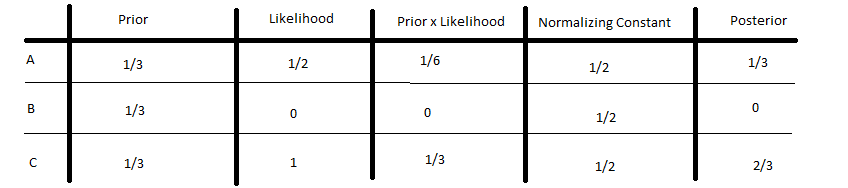

From the result, the probability of switching option will give you higher change to win the car. 

Let move to another problem "M&M" that is quite the same as Cookie problem. We have 2 types of candy which was produced in before and after 1995. Type 1994 included : 30% brown, 20% yellow, 20% red, 10% green, 10% orange, 10% tan. Type 1996 included : 24% blue, 20% green, 16% orange, 14% yellow, 13% red, 13% brown. A person picked out 2 candies 'green' and 'yellow', but didn't know the production year. Find probability that 'yellow' from 1994? 

In [16]:
class MM(Pmf):                    
    def __init__(self, hypos):       
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()
    def Update(self, data):
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
    mixes = { 
        '1994':dict(brown=.3, yellow=.2, red=.2, green=.1, orange=.1, tan=.1),
        '1996':dict(blue=.24, green=.20, orange=.16, yellow=.14, red=.13, brown=.13),
        }
    def Likelihood(self, data, hypo):
        mix = self.mixes[hypo]
        like = mix[data]
        return like
    

In [21]:
def main():
    hypos = ['1994', '1996']

    pmf = MM(hypos)
    pmf.Update('yellow')
    for hypo, prob in pmf.Items():
        print (hypo, prob)

if __name__ == '__main__':
    main()    



1994 0.5882352941176471
1996 0.4117647058823529


OK so the code above is similar to Cookie. We got 0.588 if yellow candy comes from 1994 and 0.412 if it comes from 1996. Obviously, our belief in 1994 is higher because yellow makes up 20% of total. Try computing with situation of 'green', 'green' and 'yellow'

What will happen if they come from different year? I mean yellow is from 1994 AND green is from 1996 || yellow from 1996 AND green from 1994. Let review this 

In [22]:
#Suppose that yellow is always from Bag 1 and green is always from Bag 2. Our work is to map Bag x (1, 2) to Year y (1994, 1996)
class M_and_M(Suite):
    
    mix94 = dict(brown=30,
                 yellow=20,
                 red=20,
                 green=10,
                 orange=10,
                 tan=10)

    mix96 = dict(blue=24,
                 green=20,
                 orange=16,
                 yellow=14,
                 red=13,
                 brown=13)

    hypoA = dict(bag1=mix94, bag2=mix96)  #first hypo : yellow from 1994, green from 1996
    hypoB = dict(bag1=mix96, bag2=mix94)  #second hypo : yellow from 1996, green from 1994 

    hypotheses = dict(A=hypoA, B=hypoB)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: string hypothesis (A or B)
        data: tuple of string bag, string color
        """
        bag, color = data
        mix = self.hypotheses[hypo][bag]
        like = mix[color]
        return like

def main():
    suite = M_and_M('AB')

    suite.Update(('bag1', 'yellow'))
    suite.Update(('bag2', 'green'))

    suite.Print()

if __name__ == '__main__':
    main()
    

A 0.7407407407407407
B 0.2592592592592592


Summarily, we use 'Suite' instead of 'Pmf'. 

Exercise: 

In section above We said that the solution to the cookie problem generalizes to the case where we draw multiple cookies with replacement.
But in the more likely scenario where we eat the cookies we draw, the likelihood of each draw depends on the previous draws.

Modify the solution in this chapter to handle selection without replacement. Hint: add instance variables to Cookie to represent the hypothetical state of the bowls, and modify Likelihood accordingly. You might want to define a Bowl object.

Thử xét trường hợp chúng ta lần lượt lấy ra một số lượng bánh và không thế lại, nghĩa là với những lần rút sau, số lượng sẽ giảm đi. Chính vì vậy, likelihood sẽ bị PHỤ THUỘC vào những lần rút trước. Chúng ta thử đưa bài toán Cookie về như sau:
Có 2 bịch bánh, bịch 1: 30 bánh loại A và 10 bánh loại B; bịch 2: 20 bánh loại A và 20 bánh loại B. Một người lấy ngẫu nhiên lần lượt ra 2 cái bánh:
- Đều loại A
- Đều loại B
- Loại A , B
- Loại B , A

Xác định probability để cả 2 bánh đều từ bịch 1. 

- Xét trường hợp 2 bánh đều loại A. Lấy đi cái bánh đầu tiên không có gì thay đổi. Lần thứ 2 lấy đi, thì loại A ở bịch thứ 1 giảm đi 1, và total cũng giảm nốt. Đoạn code bên dưới minh họa cho điều đó. 
- Các trường hợp còn lại tương tự. 

In [26]:
pmf = Pmf()
pmf.Set('Bowl 1', 0.5)
pmf.Set('Bowl 2', 0.5)

pmf.Mult('Bowl 1', 0.75)
pmf.Mult('Bowl 1', 29/39)
pmf.Mult('Bowl 2', 0.5)
pmf.Mult('Bowl 2', 19/39)

pmf.Normalize()

print(pmf.Prob('Bowl 1'))
print(pmf.Prob('Bowl 2')) 

0.6960000000000001
0.304
